Source: https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework

In [4]:
!pip install kaggle

In [5]:
import os
from pathlib import Path

competition = "titanic"  # Change this to any Kaggle competition name
iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")

if iskaggle:
    path = Path(f"../input/{competition}")
else:
    import kaggle

    # Use .kaggle_data folders that will be gitignored
    path = Path(".kaggle_data")

    if not path.exists():
        import zipfile

        kaggle.api.competition_download_cli(competition=competition, path=str(path))
        zipfile.ZipFile(f"{path}/{competition}.zip").extractall(path)

print(f"Ready for competition: {competition}")

Ready for competition: titanic


In [6]:
import pandas as pd

In [7]:
from fastai.tabular.all import *

pd.options.display.float_format = "{:.2f}".format
set_seed(42)

In [8]:
df = pd.read_csv(path / "train.csv")

In [9]:
def add_features(df):
    df["LogFare"] = np.log1p(df["Fare"])
    df["Deck"] = df.Cabin.str[0].map(
        dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG")
    )
    df["Family"] = df.SibSp + df.Parch
    df["Alone"] = df.Family == 0
    df["TicketFreq"] = df.groupby("Ticket")["Ticket"].transform("count")
    df["Title"] = df.Name.str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df["Title"] = df.Title.map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))


add_features(df)

In [10]:
splits = RandomSplitter(seed=42)(df)

In [11]:
dls = TabularPandas(
    df,
    splits=splits,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names=["Age", "SibSp", "Parch", "LogFare", "Alone", "TicketFreq", "Family"],
    y_names="Survived",
    y_block=CategoryBlock(),
).dataloaders(path=".")

In [12]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

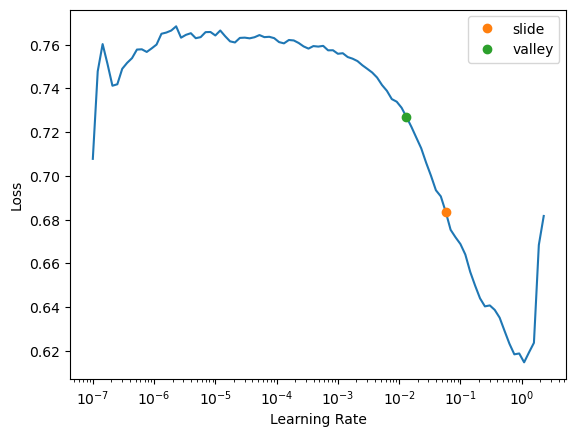

In [13]:
learn.lr_find(suggest_funcs=(slide, valley))

In [14]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.577146,0.582949,0.606742,00:00
1,0.510818,0.498523,0.786517,00:00
2,0.467023,0.459841,0.797753,00:00
3,0.439957,0.468547,0.797753,00:00
4,0.427232,0.415261,0.825843,00:00
5,0.416340,0.437362,0.820225,00:00
6,0.408347,0.413253,0.848315,00:00
7,0.400442,0.406075,0.803371,00:00
8,0.397265,0.443730,0.820225,00:00
9,0.392389,0.432267,0.831461,00:00


In [15]:
tst_df = pd.read_csv(path / "test.csv")
tst_df["Fare"] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [16]:
tst_dl = learn.dls.test_dl(tst_df)

In [17]:
preds, _ = learn.get_preds(dl=tst_dl)

In [18]:
tst_df["Survived"] = (preds[:, 1] > 0.5).int()

In [19]:
sub_df = tst_df[["PassengerId", "Survived"]]
sub_df.to_csv("submission.csv", index=False)

In [20]:
sub = pd.read_csv("submission.csv")
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Ensembling

In [21]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10, 10])
    with learn.no_bar(), learn.no_logging():
        learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [22]:
learns = [ensemble() for _ in range(5)]

In [23]:
ens_preds = torch.stack(learns).mean(0)

In [34]:
tst_df["Survived"] = (ens_preds[:, 1] > 0.5).int()
sub_df = tst_df[["PassengerId", "Survived"]]
sub_df.to_csv("submission.csv", index=False)